In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
from functools import partial
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from scipy.stats import percentileofscore
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# prepare data

In [3]:
'''This script re-fits all non-LSTM models and evaluates them for each cell / dataset.
It also takes a pre-trained LSTM and evaluates it on each cell / dataset.
'''

import os
from os.path import join as oj
import sys

from sklearn.tree import DecisionTreeRegressor
sys.path.append('../src')
import numpy as np
import torch
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
import data
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from collections import defaultdict


############ get data ######################
splits = ['train', 'test']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
length = 40
#     padding = 'end'
feat_name = 'X_same_length_extended_normalized' # include buffer X_same_length_normalized
outcome = 'Y_sig_mean_normalized'

df_fulls = []
dfs_dict = {}
for i, dsets in enumerate([['vps4_snf7'], ['vps4_snf7___key=mt']]):

    dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets,
                                                splits=splits,
                                                filter_hotspots=True,
                                                filter_short=False,
                                                lifetime_threshold=None,
                                                hotspots_threshold=25,
                                                meta=meta,
                                                normalize=False)
    df_full = pd.concat([
        dfs[(k, s)]
        for (k, s) in dfs
        if s == 'train'
    ])
    df_full['mt'] = i
    df_fulls.append(df_full)
    
    # going to use this for evaluation
    for ktup in dfs.keys():
        dfs[ktup]['mt'] = i
        dfs_dict[ktup] = dfs[ktup]

# df_full is used for fitting (was for the DNN before, now is for the baselines)
df_full = pd.concat(df_fulls).dropna()

# print('CHECK dfs_dict')
# print(dfs_dict.keys())
# for k in dfs_dict:
#     print(k, dfs_dict[k]['mt'].value_counts())

dfs = {
    ('comb', 'train'): pd.concat([
        dfs_dict[('vps4_snf7', 'train')],
        dfs_dict[('vps4_snf7___key=mt', 'train')],
    ]),
    ('comb', 'test'): pd.concat([
        dfs_dict[('vps4_snf7', 'test')],
        dfs_dict[('vps4_snf7___key=mt', 'test')],
    ]),
}

outcome = 'mt'
outcome_def = 'mt'
outcome_binary = 'mt'
# print('dfs.keys())
############ finish getting data data ######################


ds = {
    (k, v): dfs[(k, v)]
        for (k, v) in sorted(dfs.keys(), key=lambda x: x[1] + x[0])
        #if not k == 'clath_aux+gak_a7d2_new'
        }
print('CHECK ds')
for k in ds:
    print(k, ds[k]['mt'].value_counts())

epoch = 15
checkpoint_fname = f'../models/vps_distingish_mt_vs_wt_epoch={epoch}.pkl'
results = pkl.load(open(checkpoint_fname, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])
for i, (k, v) in enumerate(ds.keys()):
    if v == 'test':
        df = ds[(k, v)]
        X = df[feat_names[:1]]
        y_reg = df[outcome_def] # df['Y_sig_mean_normalized'].values
        y = df[outcome_binary].values
        #preds = np.logical_and(dnn.predict(X), df['X_max'] > 1500).values.astype(int)  
        preds = dnn.predict(X)
        print('shape', y.shape)
        print('means', (preds > 0.5).mean(), y.mean())
        print('acc', np.mean((preds > 0.5) == y))

100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


CHECK ds
('comb', 'test') 0    2951
1    1210
Name: mt, dtype: int64
('comb', 'train') 0    8962
1    3378
Name: mt, dtype: int64
shape (4161,)
means 0.41961067051189616 0.2907954818553232
acc 0.87070415765441


# Scatter plot
Show that preds correlates with common features and that erors are where vps may not get recruited.

In [ ]:
plt.hist()

# scatter plots

Text(0.5, 0, 'Groundtruth Regression (vps4 max)')

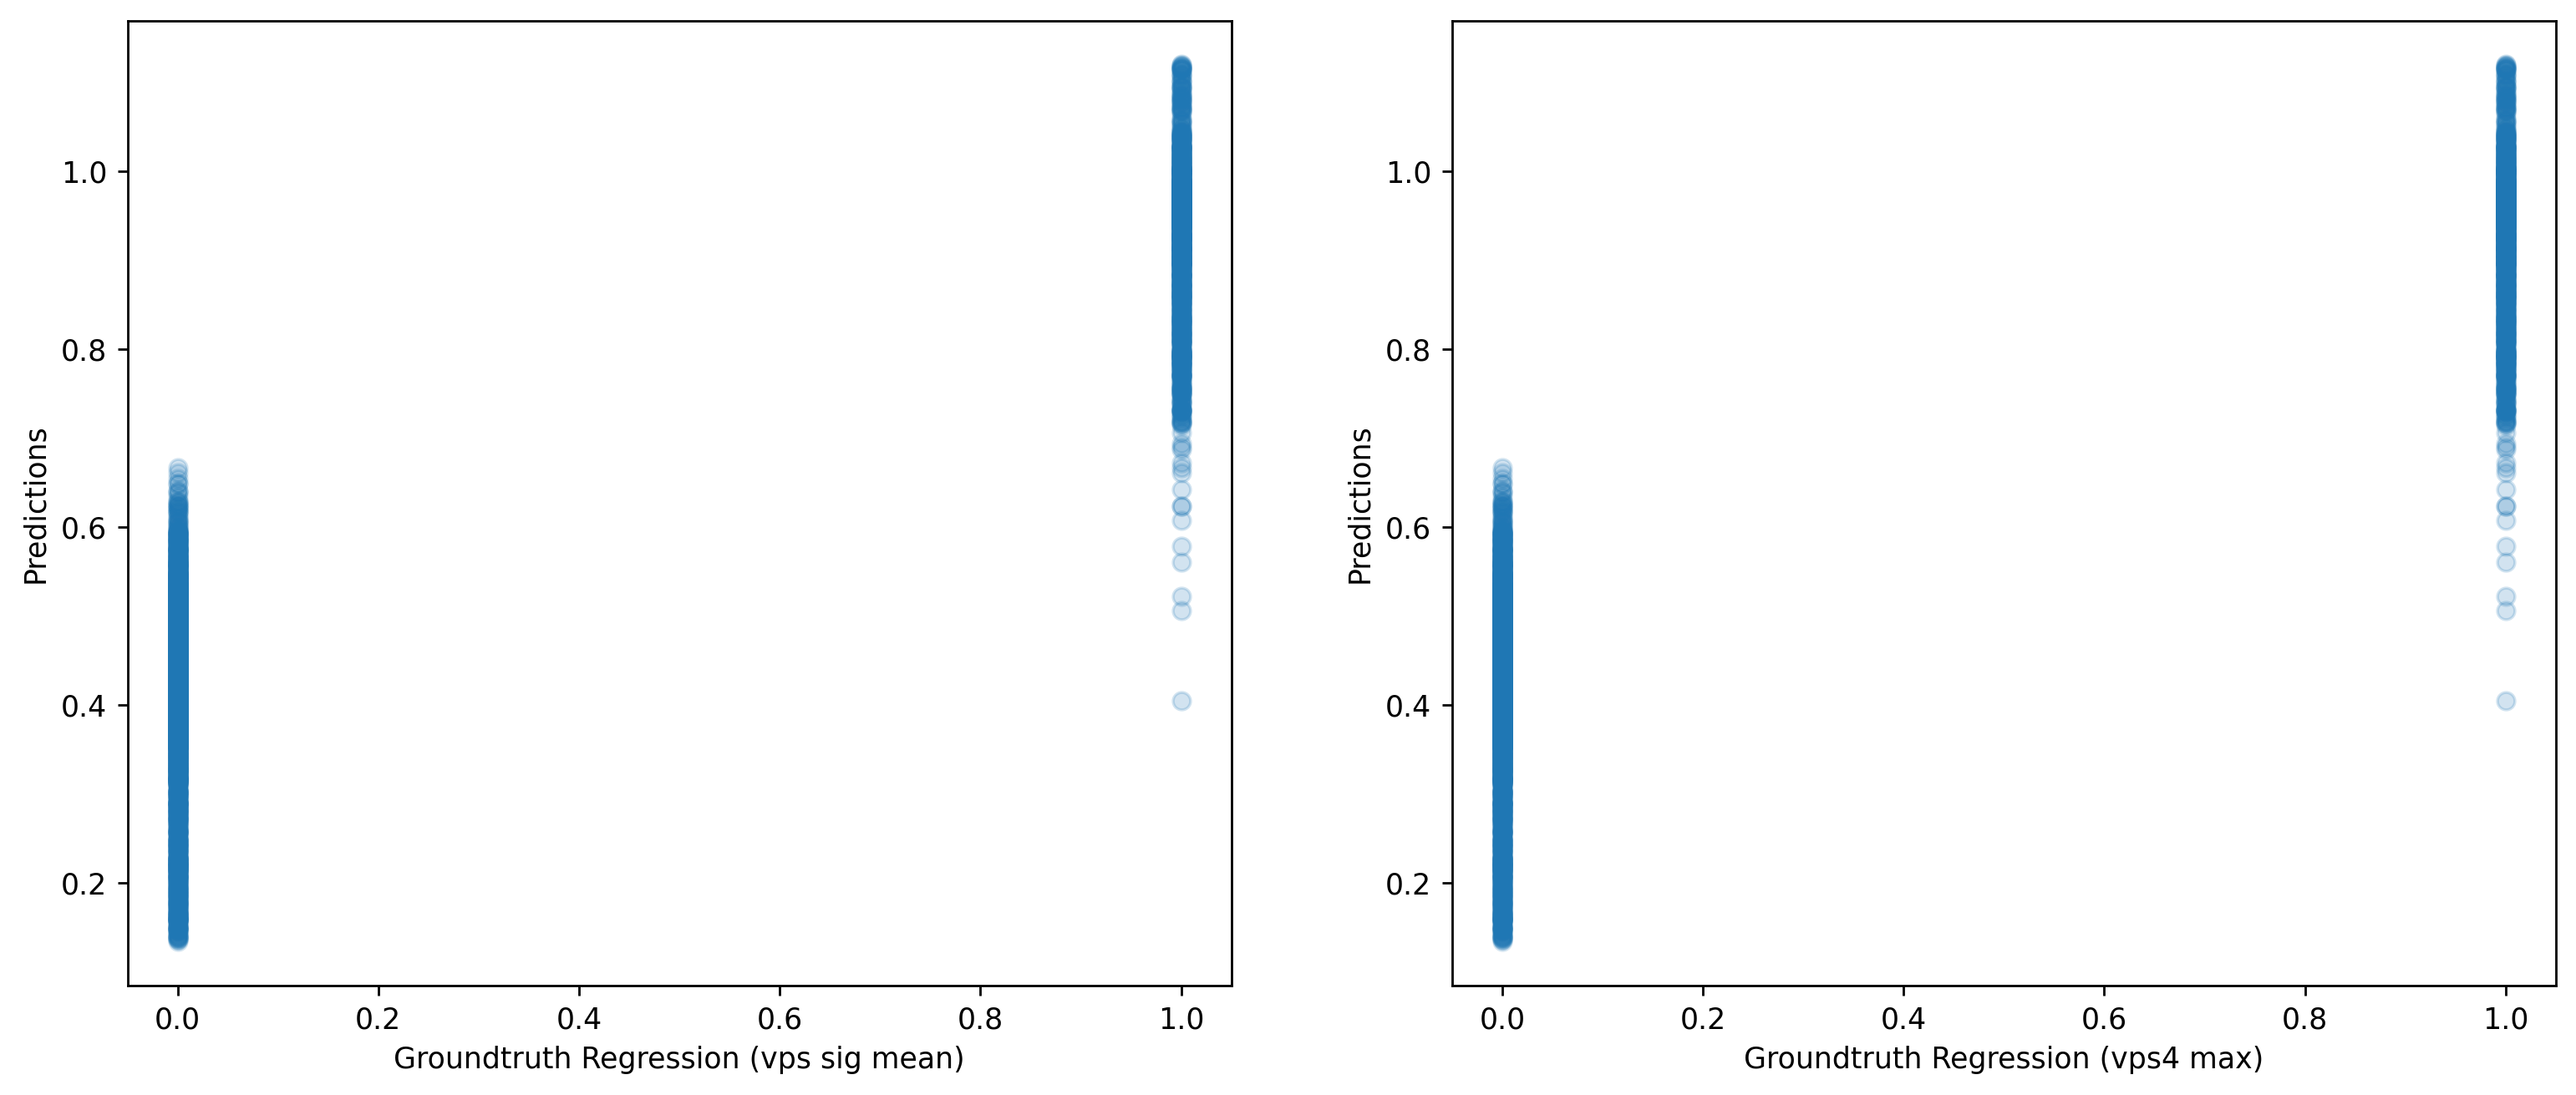

In [5]:
plt.figure(figsize=(15, 6), dpi=250)
plt.subplot(121)

ys = df['Y_sig_mean_normalized'].values
preds_perc = preds # [percentileofscore(ys, score=p) for p in preds]
plt.plot(ys, preds_perc, 'o', alpha=0.2)
plt.ylabel('Predictions')
plt.xlabel('Groundtruth Regression (vps sig mean)')

plt.subplot(122)
ys = df['Y_max'].values
preds_perc = preds # [percentileofscore(ys, score=p) for p in preds]
plt.plot(ys, preds_perc, 'o', alpha=0.2)
plt.ylabel('Predictions')
plt.xlabel('Groundtruth Regression (vps4 max)')

In [ ]:
d_mt = df[]

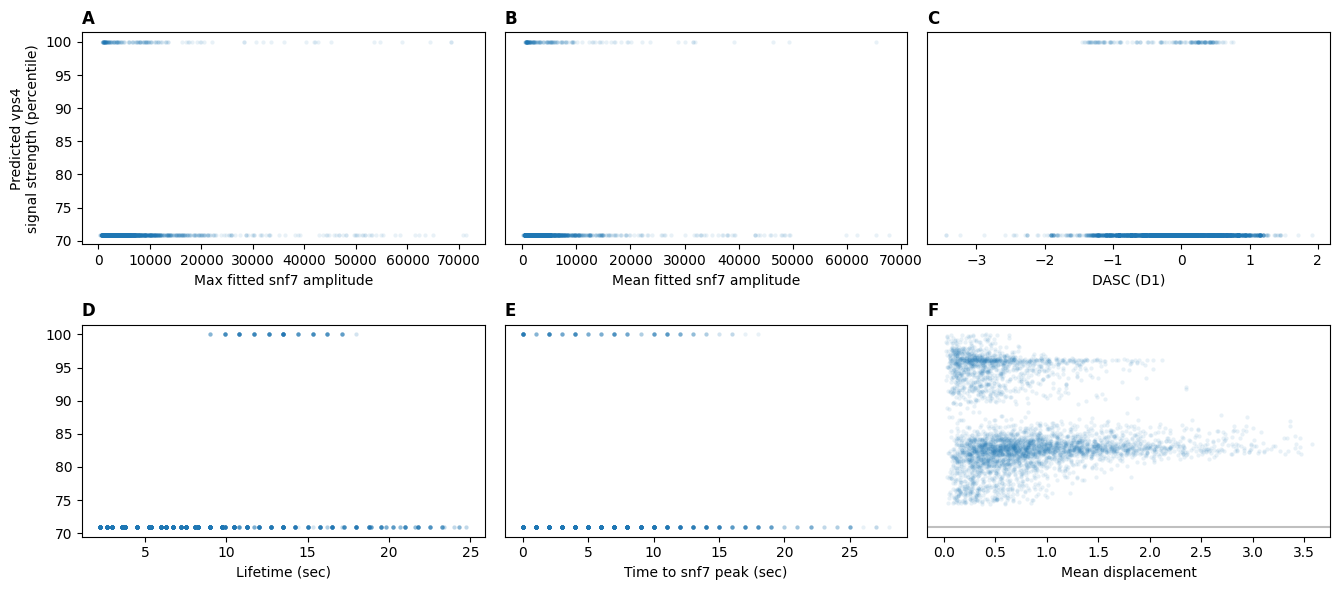

In [7]:
ys = df['mt'].values
preds_perc = [percentileofscore(ys, score=p) for p in preds]
df['preds'] = rp

R, C = 2, 3
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
kwargs = dict(
    cmap=viz.cmap,
    norm=norm,
    alpha=0.5,
    s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))

plt.subplot(R, C, 1)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_max'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Max fitted snf7 amplitude')
plt.ylabel('Predicted vps4\nsignal strength (percentile)')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
# plt.axhline(0, color='gray', alpha=0.5)
plt.yticks([])
plt.plot(df['X_mean'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Mean fitted snf7 amplitude')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_d1'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('DASC (D1)')
plt.yticks([])
plt.title('C', loc='left', fontweight='bold')

plt.subplot(R, C, 4)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['lifetime'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Lifetime (sec)')
# plt.ylabel('Predicted auxilin\nsignal strength')
# plt.yticks([])
plt.title('D', loc='left', fontweight='bold')

plt.subplot(R, C, 5)
# plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['X_peak_idx'], preds_perc, '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Time to snf7 peak (sec)')
plt.yticks([])
plt.title('E', loc='left', fontweight='bold')

plt.subplot(R, C, 6)
plt.axhline(0, color='gray', alpha=0.5)
plt.plot(df['mean_total_displacement'], df['preds'], '.', alpha=0.1, markeredgewidth=0) #, c=df['preds'], **kwargs)
plt.xlabel('Mean displacement')
plt.yticks([])
plt.title('F', loc='left', fontweight='bold')

plt.tight_layout()
# viz.savefig('top_feats_scatter')
plt.show()

# colored scatter plot (deprecated)

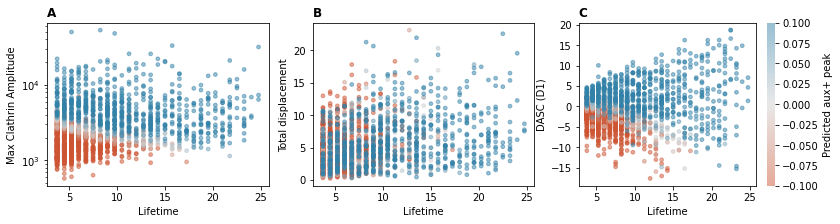

In [9]:
R, C = 1, 3
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
kwargs = dict(
    cmap=viz.cmap,
    norm=norm,
    alpha=0.5,
    s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))
plt.subplot(R, C, 1)
plt.scatter(df['lifetime'], df['X_max'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Max Clathrin Amplitude')
plt.yscale('log')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
plt.scatter(df['lifetime'], df['mean_total_displacement'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Total displacement')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
plt.scatter(df['lifetime'], df['X_d1'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('DASC (D1)')
plt.title('C', loc='left', fontweight='bold')
cb = plt.colorbar(label='Predicted aux+ peak')
cb.outline.set_visible(False)
viz.savefig('top_feats_scatter')